In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import ipywidgets as wg
from IPython.display import display
import pandas as pd
import math

from mag_field.planet import Planet
from mag_field.libbfield import getBr as calcBr

In [2]:
# Preload cached data for speed up calculation
dataframe = None
try: 
	dataframe = pd.read_csv("./data/cached_disturbances_time_series.csv")
except:
	dataframe = None

In [3]:
# Given Mission Constant and ScienceCraft Dimensions
mission_duration = 2.16e5
boom_mass = 6
boom_length = 32.5
bus_mass = 36
bus_length = 10
max_spectorometer_distance_from_center = 20

# Electrospray Thrusters Dimensioning Calculations
fuel_mass_per_impulse_per_unit = 1.7e-2 / 165
force_per_thruster_unit = 5e-6

unit_impulse_req = force_per_thruster_unit * mission_duration

single_unit_fuel_mass = unit_impulse_req * fuel_mass_per_impulse_per_unit
single_unit_mass = 1.8e-2 + single_unit_fuel_mass

power_consumption_per_unit = 1e-2
desired_torque_output_xy = np.max(dataframe["T"]) * 4 # 4x disturbance torque for x and y
desired_torque_output_z = np.max(dataframe["T"]) # 1x disturbance torque for z (b/c it will never reach 1x as most the current disturbance is in the xy)
number_of_units_per_array = math.ceil(desired_torque_output_xy / (force_per_thruster_unit * boom_length * 4))
print(number_of_units_per_array) # ~ 1 (2x the value given)
# ethruster_array_mass = 
# ethruster_array_power_usage = 130e-3

thruster_arrays = 8 + 4

e_thrusters_total_mass = single_unit_mass * number_of_units_per_array * thruster_arrays
e_thrusters_total_power_consumption = power_consumption_per_unit * number_of_units_per_array * thruster_arrays
print("Total mass of all e-thrusters: ", e_thrusters_total_mass) # total ethrusters system mass
print("Total power consumption for all e-thrusters: ", e_thrusters_total_power_consumption) # total power consumption for ethrusters

5
Total mass of all e-thrusters:  1.0866763636363634
Total power consumption for all e-thrusters:  0.6000000000000001


In [4]:
##### General Constants #######

# ScienceCraft Constants
additional_boom_end_mass = e_thrusters_total_mass / 4


Iz = (4 * ((boom_mass * boom_length ** 2 / 3) + (additional_boom_end_mass * boom_length ** 2)))
Ix = Iz / 2
Iy = Iz / 2

I = np.array([Ix, Iy, Iz]) # A vector representing the moment of inertia about the 3 axes

if dataframe is not None:
	t = dataframe["t"]
else:
	t = np.arange(0, mission_duration, 1)

t /= 60 * 60 

In [5]:
# Gravity gradient disturbances constants

# Relevant constants
G = 6.6743e-11

triton_mass = 2.1390e22

mu_neptune = 6.836529e15
mu_triton = G * triton_mass

# Radii of Neptune and Triton
r_neptune = 2.4622e7
r_triton = 1.35e6

# Distance from Neptune and Triton
R_neptune = np.array([4e9, 2e8]) + r_neptune # distance range from furthest to closest
R_triton = np.array([4e9, 3e6]) + r_triton

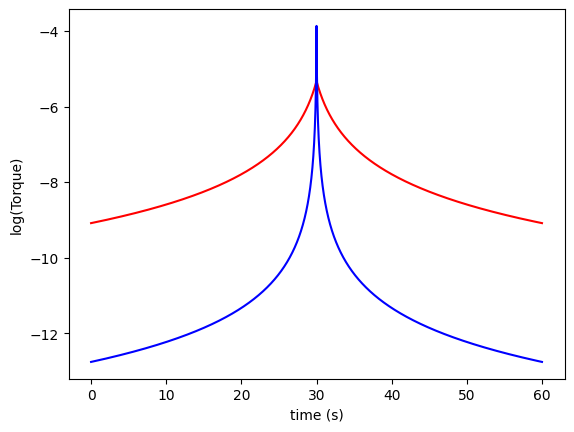

In [6]:
# Time series distances for Neptune and Triton
Rt_neptune = np.linspace(*R_neptune, int(t.size/2))
Rt_neptune = np.concatenate((Rt_neptune, np.flip(Rt_neptune)))

Rt_triton = np.linspace(*R_triton, int(t.size/2))
Rt_triton = np.concatenate((Rt_triton, np.flip(Rt_triton)))

# Function for calculating the gravity gardient disturbance torque
def Tg(R, mu, I):
	Ix, Iy, Iz = I
	coeff = (3 * mu) / (2 * R ** 3)
	Tg = np.abs(Iz - Iy) * coeff
	return Tg

if dataframe is not None:
	Tg_neptune = dataframe["Tg_neptune"]
	Tg_triton = dataframe["Tg_triton"]
else:
	Tg_neptune = np.vectorize(lambda R: Tg(R, mu_neptune, I))(Rt_neptune)
	Tg_triton = np.vectorize(lambda R: Tg(R, mu_triton, I))(Rt_triton)


# Plotting the gravitational disturbance torque from Neptune and Triton relative to each other
plt.plot(t, np.log10(Tg_neptune), color="red")
plt.plot(t, np.log10(Tg_triton), color="blue")
plt.xlabel("time (s)")
plt.ylabel("log(Torque)")
plt.show()


Max. Neptune B (micro-Teslas): 0.0346420464788552
Planet: Neptune
l_max = 3
Dipole tilt (degrees) = 46.900530
0.1
cartopy library not available, using Hammer projection


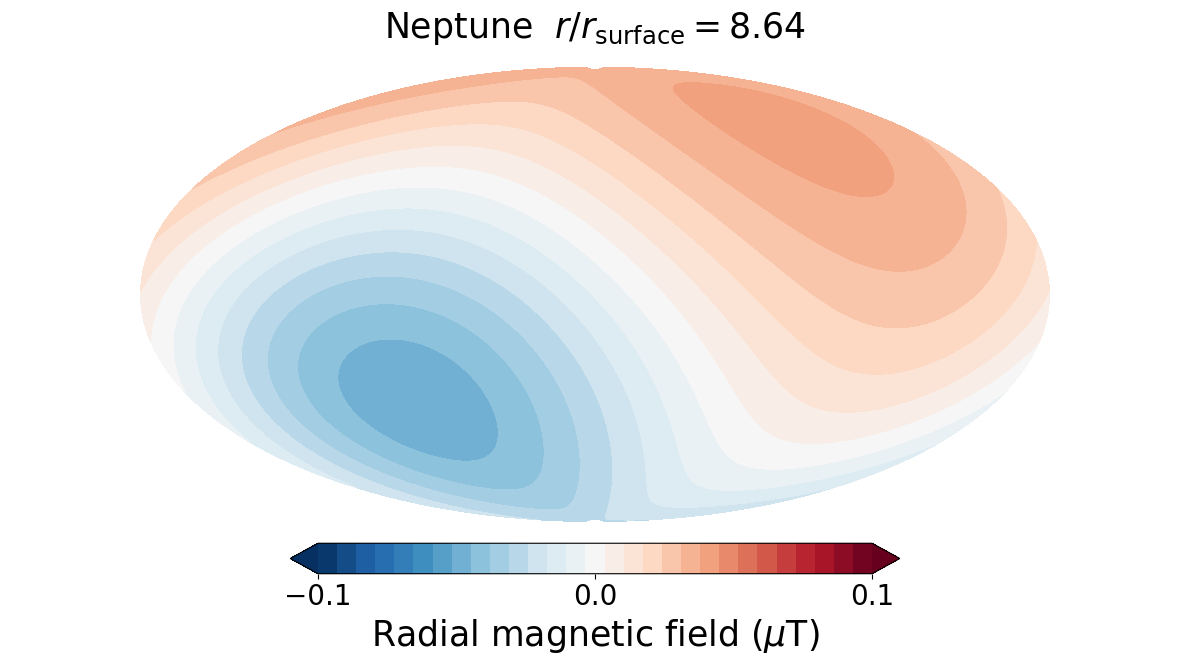

In [7]:
# Magnetic Field Disturbance Torque Calculation
neptune = Planet(name="neptune", datDir="mag_field/data/", info=False)
r = R_neptune[1] / r_neptune 
_, _, Br, _, _ = calcBr(planet=neptune, r=r, info=False)
max_Br_at_min_distance = np.max(Br)
print(f"Max. Neptune B (micro-Teslas): {max_Br_at_min_distance}") # Maximum magnetic field strength at a distance R from the center of mass of neptune
# 8.64 is the lowest value that the simulation can reach but 
# Because it's the highest distance that the mag field engine can plot up to
# In our case the closest distance is r = 9.1228 * R_neptune at which the field is predicted to be even lower than the current calculated value
neptune.plot(r=8.64)

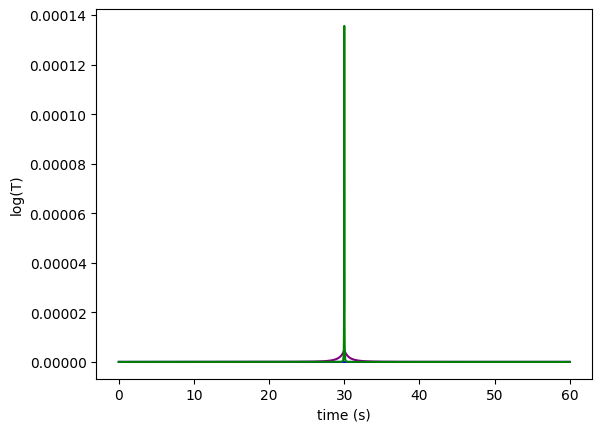

In [8]:
# Final magnetic field calculation:

def calc_B(R):
	r = R / r_neptune 
	_, _, Br, _, _ = calcBr(planet=neptune, r=r, info=False)
	max_Br = np.max(Br)
	return max_Br 

D = 0.4 # in A*m^2 (estimation of the sciencecraft's dipole coming from sample results from this paper https://ieeexplore.ieee.org/document/6978903)

# Returns the magnetic field disturbance torque as a function of distance in Nm
def Tm(R):
	B = calc_B(R)
	# B = 3.4642e-2 # Use max value for similifcation of the calculation
	
	# B in terms of Teslas instead of microteslas
	B_T = B * 1e-6
	return B_T * D

if dataframe is not None:
	Tm_neptune = dataframe["Tm_neptune"]
else:
	Tm_neptune = np.vectorize(Tm)(Rt_neptune)

# Plotting the gravitational disturbance torque from Neptune and Triton relative to each other
plt.plot(t, Tm_neptune, color="blue")
plt.plot(t, Tg_neptune, color="purple")
plt.plot(t, Tg_triton, color="green")
plt.xlabel("time (s)")
plt.ylabel("log(T)")
plt.show()


In [9]:
# Solar Radiation Pressure Calculation

def Ts(t):
	# Ts = torque_solar(veh.dim, veh.CG, 0, veh.mat); 
	# Calculate solar radiation pressure torque
	Js =  15 # solar constant

	c = 2.99792458e8 # speed of light
	q_refl = 0.6 # Coeffecient of reflectivity
	# Find surface area of the largest face of orbit
	A_s = boom_length ** 2 * 4
	F = Js * A_s * q_refl / c
	# now calculate torque
	# use CG to find maximum worst case moment arm

	# CG can be assumed to be the same as center of mass for a mass in a uniform gravitational field
	mass_total = 60
	
	CG = [0, 0, 3]
	# If the torque completely hits one side that's directly facing (cannot hit both sides as they will result in 0 torque)
	# 1/2 is coming from the fact that not all of the F_srp force is on the edge of the spectorometer
		# more like a uniform distribution
	# 1/2 coming from the fact that the area being hit cannot be the 
	# total area but instead half so that the torques on the opposite sides do not cancel out
	T_solar = F * 1/2 * max_spectorometer_distance_from_center * 1/2 
	return T_solar
if dataframe is not None:
	Ts_t = dataframe["Ts_t"]
else:
	Ts_t = np.vectorize(Ts)(t)

In [10]:
# # Caching block for reducing computation time
# T = Tg_neptune + Tg_triton + Tm_neptune + Ts_t
# T_lg = np.log10(T)

# combined_data = {
# 	"t": t,
# 	"Rt_neptune": Rt_neptune,
# 	"Rt_triton": Rt_neptune,
# 	"Tm_neptune": Tm_neptune,
# 	"Tg_neptune": Tg_neptune,
# 	"Tg_triton": Tg_triton,
# 	"Ts_t": Ts_t,
# 	"Tm_neptune_lg": np.log10(Tm_neptune),
# 	"Tg_neptune_lg": np.log10(Tg_neptune),
# 	"Tg_triton_lg": np.log10(Tg_triton),
# 	"Ts_t_lg": np.log10(Ts_t),
# 	"T": T,
# 	"T_lg": T_lg
# }
# rounded_data = {}
# for key, value in combined_data.items():
# 	rounded_data[key] = np.round(value, 4)

# dataframe = pd.DataFrame(combined_data)
# print(dataframe)
# dataframe.to_csv("./data/cached_disturbances_time_series.csv", encoding="utf-8")

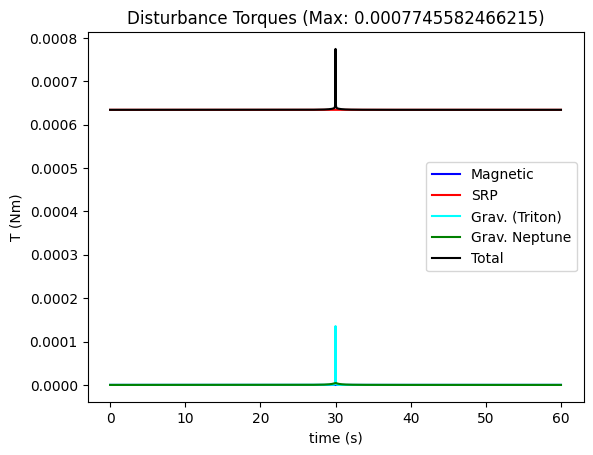

In [11]:
# Plotting the total torque over the course of the mission
if dataframe is not None:
	T = dataframe["T"]
	T_lg = dataframe["T_lg"]
else:
	T = Tg_neptune + Tg_triton + Tm_neptune + Ts_t
	T_lg = np.log10(T)

plt.plot(t, Tm_neptune, color="blue", label="Magnetic")
plt.plot(t, Ts_t, color="red", label="SRP")
plt.plot(t, Tg_triton, color="cyan", label="Grav. (Triton)")
plt.plot(t, Tg_neptune, color="green", label="Grav. Neptune")
plt.plot(t, T, color="black", label="Total")
plt.legend()

plt.title(f"Disturbance Torques (Max: {np.max(T)})")
plt.xlabel("time (s)")
plt.ylabel("T (Nm)")
plt.show()


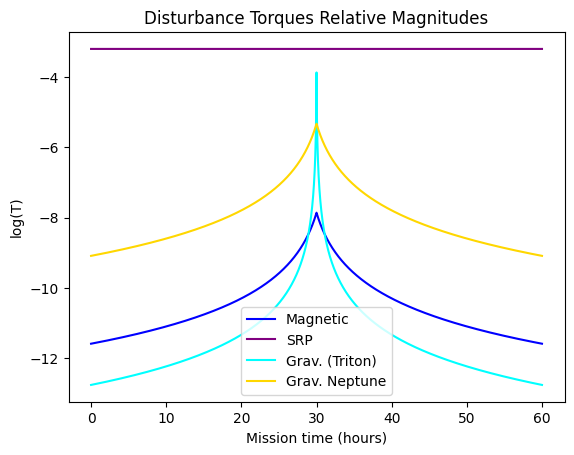

In [12]:

# Plotting the total torque (order of magnitude) over the course of the mission
if dataframe is not None:
	Tm_neptune_lg = dataframe["Tm_neptune_lg"]
	Tg_triton_lg = dataframe["Tg_triton_lg"]
	Tg_neptune_lg = dataframe["Tg_neptune_lg"]
	Ts_t_lg = dataframe["Ts_t_lg"]
else:
	Tm_neptune_lg = np.log10(Tm_neptune)
	Ts_t_lg = np.log10(Ts_t)
	Tg_triton_lg = np.log10(Tg_triton)
	Tg_neptune_lg = np.log10(Tg_neptune)

plt.plot(t, Tm_neptune_lg, color="blue", label="Magnetic")
plt.plot(t, Ts_t_lg, color="purple", label="SRP")
plt.plot(t, Tg_triton_lg, color="cyan", label="Grav. (Triton)")
plt.plot(t, Tg_neptune_lg, color="gold", label="Grav. Neptune")
# plt.plot(t, T_lg, color="black", label="Total")
plt.legend()

plt.title(f"Disturbance Torques Relative Magnitudes")
plt.xlabel("Mission time (hours)")
plt.ylabel("log(T)")
plt.show()